# Annotation of Splenic Stroma

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

In [2]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'

## Load Stromal data

In [15]:
split="STROMA"
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

# Add annotation obs
# anno_dir = "/nfs/team205/ed6/bin/Pan_fetal_immune/metadata/manual_annotation/"
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [28]:
add_obs = anno_obs[['uniform_label',
       'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ',
       'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex',
       'Processing_method', 'AnnatomicalPart', 'Sample']]

In [32]:
adata.obs = pd.concat([adata.obs, add_obs.loc[adata.obs_names]],1)

### Subset 
To splenic stroma

In [39]:
sp_adata = adata[(adata.obs['organ'] == "SP")]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [42]:
s="SPLEEN_STROMA"
sp_adata.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'anno_lvl_2_final_clean' as categorical
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'uniform_label' as categorical
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'uniform_label_expanded_merged' as categorical
Trying to set attribute `.obs` of view, copying.
Variabl

In [43]:
sc.pp.normalize_per_cell(sp_adata, counts_per_cell_after=10e4)
sc.pp.log1p(sp_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [44]:
sp_adata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))

### Re-embed with scVI
Copying what I run on GPU nodes

In [ ]:
def load_data_split(data_dir, timestamp, split):
    # Load estimated gene dispersions for HVG selection
    # Generated running `Pan_fetal_immune/utils/PFI_pp_4_HVG_stats.py`
    adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split))

    ### Load count data
    adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    adata_raw.var_names_make_unique()

    # Load obs
    new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)
    adata_raw.obs = new_obs.loc[adata_raw.obs_names]

    ## Load var
    adata_raw.var = adata_lognorm_var.copy()

    ## Add batch key
    adata_raw.obs["bbk"] = adata_raw.obs["method"] + adata_raw.obs["donor"]
    return(adata_raw)

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)
    arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        )
    vae = scvi.model.SCVI(adata, n_latent=n_dims, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )
    return(vae)

def scvi_split(s, 
               data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/",
               timestamp = "20210429"
              ):
    adata_raw = load_data_split(data_dir, timestamp, s)
    adata_raw = prep_scVI(adata_raw, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)
    vae = train_scVI(adata_raw, n_dims=20)
    adata_raw.obsm["X_scVI"] = vae.get_latent_representation()
    ## Save embedding
    outname = "PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.npy".format(t=timestamp, s=s)
    np.save(data_dir + outname, adata_raw.obsm["X_scVI"])
    ## Plot convergence
    sns.set_context("talk")
    plt.plot(vae.history["elbo_train"], label="Training");
    plt.plot(vae.history["elbo_validation"], label="Validation");
    plt.legend();
    plt.xlabel("epoch");
    plt.ylabel("ELBO");
    plt.savefig("/home/jupyter/mount/gdrive/Pan_fetal/Updates_and_presentations/scvi_training_elbo_{s}.pdf".format(s=s), bbox_inches="tight")
    # save the reference model
    model_dir = 'scvi_{s}_model/'.format(s=s)
    if not os.path.exists(data_dir + model_dir):
        os.mkdir(data_dir + model_dir)
    vae.save(data_dir + model_dir, overwrite=True)

In [ ]:
## Run on GPU
# scvi_split("SPLEEN_STROMA")

### Clustering + UMAP viz

Running `src/3_clustering/cluster_scvi.py`

### Visualize clusters

In [45]:
def load_scvi_outs(adata, emb_file, load_clustering=True):
    X_scVI_emb = np.load(emb_file)
    X_scVI_umap = np.load(emb_file.rstrip(".npy") + ".UMAP.npy")
    adata.obsm["X_scvi"] = X_scVI_emb
    adata.obsm["X_umap"] = X_scVI_umap
    if load_clustering:
        X_scVI_clust = pd.read_csv(emb_file.rstrip(".npy") + ".clustering.csv", index_col=0)
        adata.obs["scvi_clusters"] = X_scVI_clust.loc[adata.obs_names]["leiden_150"].astype("category")

def load_data_split(data_dir, timestamp, split):
    # Load estimated gene dispersions for HVG selection
    # Generated running `Pan_fetal_immune/utils/PFI_pp_4_HVG_stats.py`
    adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)

    ### Load gex data
    adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    adata_raw.var_names_make_unique()

    # Load obs
    new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)
    adata_raw.obs = new_obs.loc[adata_raw.obs_names]

    ## Load var
    adata_raw.var = adata_lognorm_var.copy()

    ## Add batch key
    adata_raw.obs["bbk"] = adata_raw.obs["method"] + adata_raw.obs["donor"]
    return(adata_raw)

data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [47]:
split="SPLEEN_STROMA"
adata = load_data_split(data_dir, timestamp, split)
emb_file = data_dir + "scVI_outs/" + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.npy'.format(t=timestamp, s=split)

load_scvi_outs(adata, emb_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical
... storing 'bbk' as categorical
... storing 'GeneName' as categorical


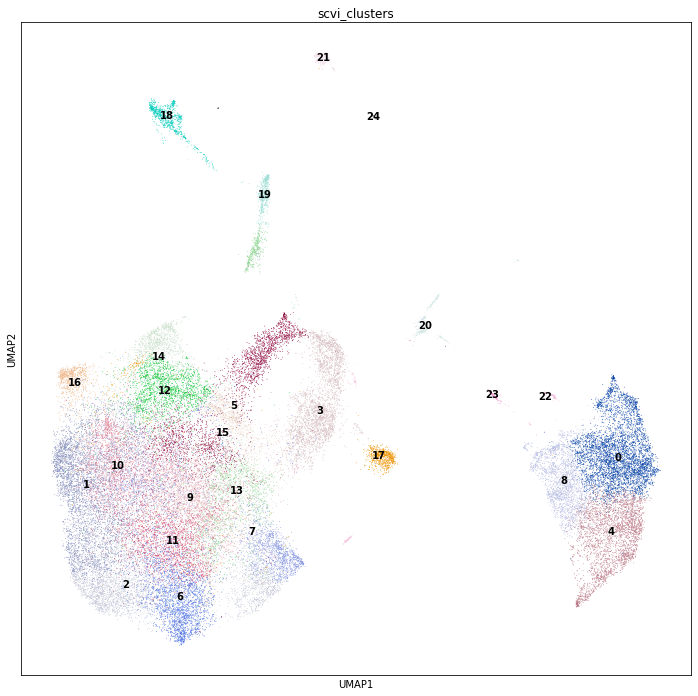

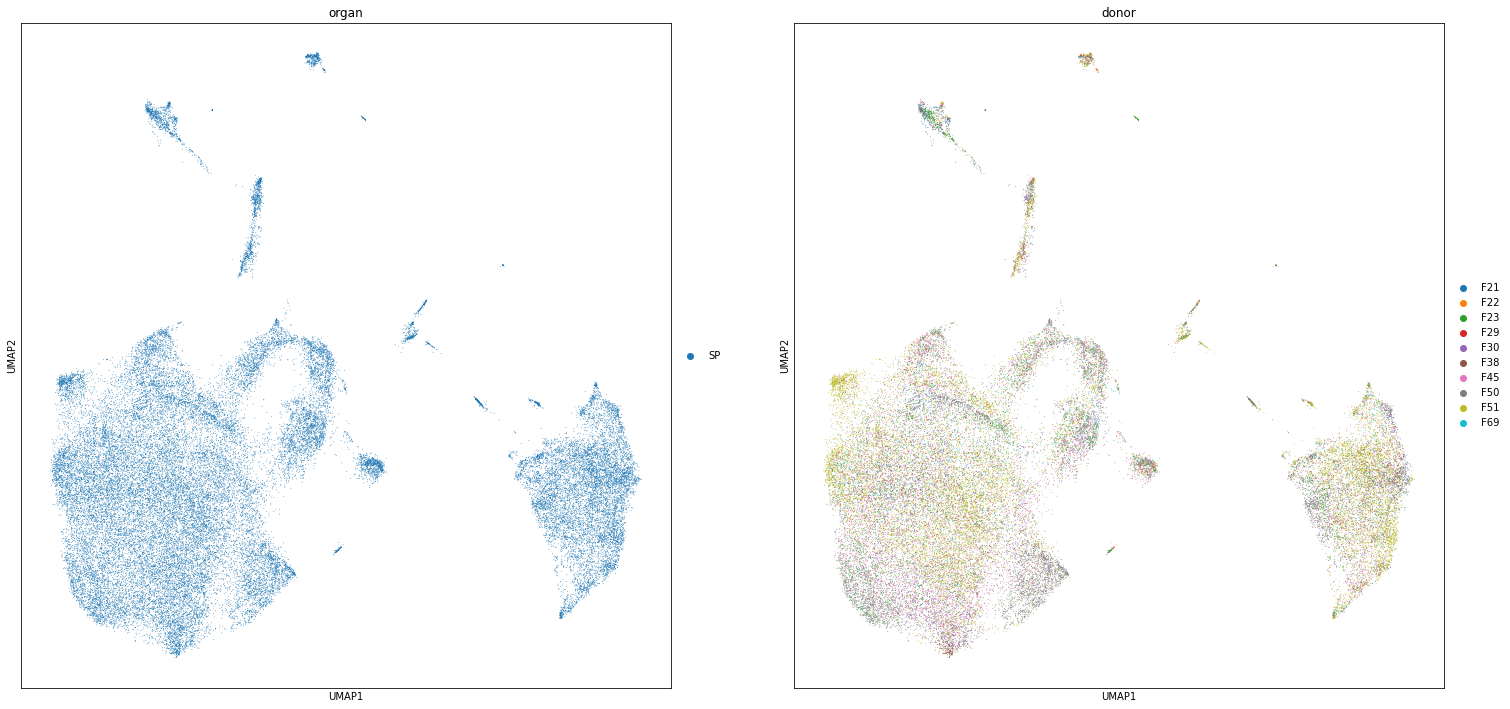

In [48]:
plt.rcParams["figure.figsize"] = [12,12]
sc.pl.umap(adata, color=["scvi_clusters"], legend_loc="on data")
sc.pl.umap(adata, color=["organ", "donor"])

Load annotations

In [49]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp), index_col=0)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [50]:
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

... storing 'anno_lvl_2_final_clean' as categorical


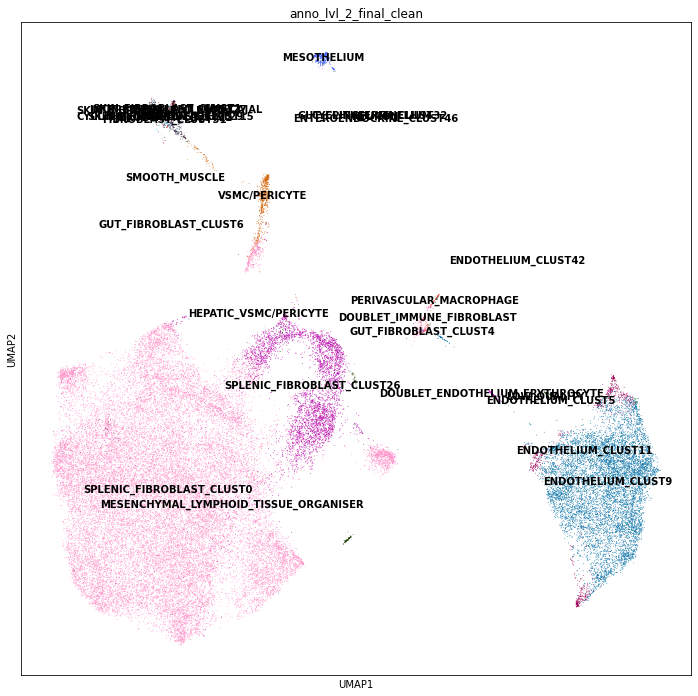

In [51]:
sc.pl.umap(adata, color=["anno_lvl_2_final_clean"], legend_loc="on data")

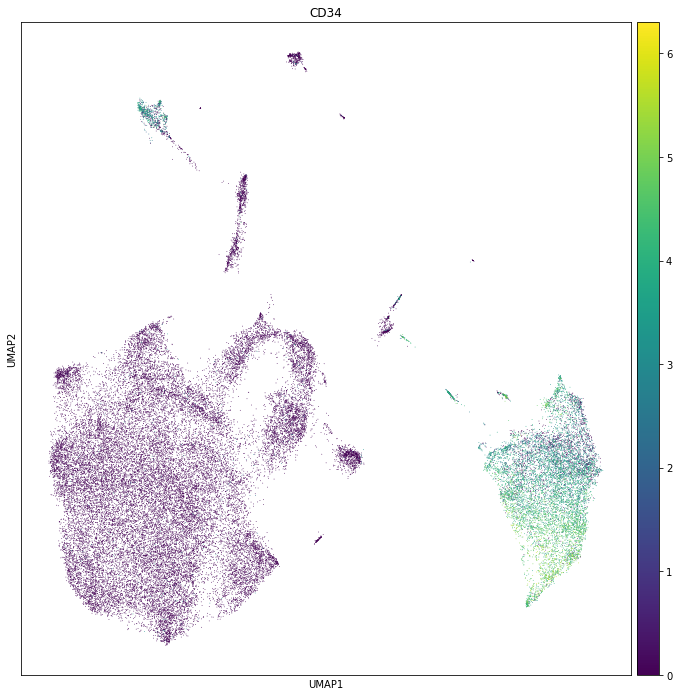

In [52]:
sc.pl.umap(adata, color=["CD34"])

In [54]:
adata.obs["leiden_150"] = adata.obs["scvi_clusters"]
adata.write_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))

In [55]:
data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split)

'/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.SPLEEN_STROMA.embedding.h5ad'